<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Impl%C3%A9mentation_Triplet_loss_stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras implementation of Triplet Loss

In [0]:
#!pip install git+https://github.com/tensorflow/docs
#!git clone https://github.com/GuillaumeMagnette/Stage_Tritons.git
#!pip install numba


import urllib

#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)



In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import save_img

from numpy import linalg as LA

In [0]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import os
import pathlib
import shutil
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/newtsAugmented.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage import transform
from skimage.transform import rotate, AffineTransform, swirl
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage


import numba
from numba import jit

In [0]:
tf.executing_eagerly()
print(numba.__version__)

0.48.0


In [0]:
from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/Stage_Dataset.zip


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Séparation en train et test set

In [0]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [0]:
from random import random, uniform

# load Image
img_path = '/content/database/Bascha_P01_T05_K20_U_Larva_8359_20190717223645.jpg'
#img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1039_20190607040030.jpg'
#img_path = '/content/database/Bascha_P01_T06_K13_M_Adult_1008_20190601154259.jpg'
img_path = '/content/database/Bascha_P01_T05_K18_M_Adult_6164_20190703234211.jpg'
img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
img_path = '/content/database/Bascha_P01_T02_K13_M_Adult_750_20190531073133.jpg'

def preprocess_newts(img_path, input_shape):
  #img = imread(img_path)
  img = cv2.imread(img_path)
# plot original Image
#plt.imshow(img)
#plt.show()
#cv2_imshow(img)


  h,w=img.shape[0:2]

### Add borders around the image to have more room for wraping and swirling
  shift = 20
  base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
  base=np.zeros(base_size)
  cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
  base[shift:h+shift,shift:w+shift]=img # this works
  img = base
#print(img)
#cv2_imshow(img)

  h,w=img.shape[0:2]

  #print("Augmentation par déformation")

### image shearing using sklearn.transform.AffineTransform
# try out with differnt values of shear 

  shear = uniform(-.3, .3)
  #print(shear)
  tfr = AffineTransform(shear=shear)
  sheared = transform.warp(img, tfr, order=1, preserve_range=True,mode='constant', cval=255)
#sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
#plt.title('shear')
#plt.imshow(sheared)
#v2_imshow(sheared)

### image swirling using sklearn swirl
# keep strength  between -1 and 1
# maximum radius = 500
# mode = constant because in case of "wrap" some parts of the newts go the other sides of the image. Bad for the training of the neural network
  strength = uniform(-1, 1)
#print(strength)
  swirled = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
#plt.imshow(swirled)
#cv2_imshow(swirled)

  img = swirled
  #print(img.shape)
  img = img.astype(np.uint8)

  img0 = cv2.equalizeHist(img[:,:,0])
  img1 = cv2.equalizeHist(img[:,:,1])
  img2 = cv2.equalizeHist(img[:,:,2])
  img[:,:,0] = img0
  img[:,:,1] = img1
  img[:,:,2] = img2


#cv2_imshow(img)

  h,w=img.shape[0:2]



  hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
  lower_yellow = np.array([5,15,25]) 
  upper_yellow = np.array([100,240,255]) 

  lower_yellow2 = np.array([160,15,25]) 
  upper_yellow2 = np.array([180,240,255]) 
#hsl(63, 20%, 81%)
  lower_black = np.array([0,0,50]) 
  upper_black = np.array([35,75,255]) 

  lower_black2 = np.array([155,0,50]) 
  upper_black2 = np.array([180,75,255]) 
# Here we are defining range of yellow color in HSL 
# This creates a mask of yellow coloured  
# objects found in the frame. 
  mask = cv2.inRange(hls, lower_yellow, upper_yellow)
  mask2 = cv2.inRange(hls, lower_yellow2, upper_yellow2)
  mask_b = cv2.inRange(hls, lower_black, upper_black) 
  mask_b2 = cv2.inRange(hls, lower_black2, upper_black2)

  mask = mask_b2+mask_b+mask+mask2
# The bitwise and of the frame and mask is done so  
# that only the blue coloured objects are highlighted  
# and stored in res 
#res = cv2.bitwise_or()
  res = cv2.bitwise_and(img,img, mask= mask) 
#cv2_imshow(img) 
#cv2_imshow(mask)
#cv2_imshow(res) 


  mask_blur = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)

  threshMap = cv2.threshold(mask_blur.astype("uint8"), 0, 255,
	  cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  kernel = np.ones((7,7),np.uint8)
  threshMap = cv2.dilate(threshMap, kernel)
  threshMap = cv2.erode(threshMap, kernel)


#cv2_imshow(mask_blur)
#cv2_imshow(threshMap)

  canny_output = auto_canny(threshMap, sigma = 0.3)
#canny_output = cv2.convertScaleAbs(canny_output)
  kernel = np.ones((9,9),np.uint8)
  threshed = cv2.dilate(canny_output,kernel)


#print(canny_output[1])
#plt.imshow(canny_output)
#plt.colorbar()
#plt.show()


## findContours(查找轮廓)
  cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

#print(cnts[0])
#plt.imshow(threshed)
#plt.colorbar()
#plt.show()
#print(cnts.shape)

#new,contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours= sorted(contours, key = cv2.contourArea, reverse = True)[:4]
#c=contours[0]
#print(cv2.contourArea(c))
#final = cv2.drawContours(img, [c], -1, (255,0, 0), 3)


#cnts = canny_output
#cnts = sorted(canny_output, key=cv2.contourArea)
## sorted by area(按照面积排序)
  cnts = sorted(cnts, key=cv2.contourArea)

## get the maximum's boundinRect(获取最大边缘的外接矩形)
  cnt = cnts[-1]

## create mask(创建掩模)
  mask = np.ones_like(threshMap, np.uint8)*cv2.GC_PR_BGD
  cv2.drawContours(mask, cnt, -1, cv2.GC_FGD, -1)

#print("shape of cnt: {}".format(cnt.shape))

#plt.imshow(mask)
#plt.colorbar()
#plt.show()

#new_image = cv2.bitwise_and(img,img,mask=mask)
#print(mask)
  new_image = threshMap.copy()
  new_image[mask == 2] = 0  # Set values not masked to be 0

#plt.imshow(new_image)
#plt.colorbar()
#plt.show()

#retval = cv2.contourArea(cnt)
#print(retval)

  rect = cv2.minAreaRect(cnt)
  #print("rect: {}".format(rect))

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  width = int(rect[1][0])
  height = int(rect[1][1])

  src_pts = box.astype("float32")
  dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(img, M, (width, height))

#cv2_imshow(warped)

  #print("Augmentation par couleurs")
  image = tf.image.random_brightness(warped, max_delta=0.15) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image,0.5,2)
  image = tf.image.random_saturation(image,0.5,2)

  height = input_shape[0]
  width = input_shape[1]
  
  if (image.shape[0] < image.shape[1]):
    image = tf.image.resize(image, [width, height])
    #print("height < width")
    image = tf.image.transpose(image)
  else:
    image = tf.image.resize(image, [height, width])
    #print("height > width")

  return image

#from keras.preprocessing.image import array_to_img, img_to_array
#img = img_to_array(image)
#cv2_imshow(img.astype('uint8'))



In [0]:
input_shape = (100,100,3)


def augmentationImage(img_path,img_aug_path, input_shape):

  
  !rm -rf /content/databaseAug
  data = pd.read_csv('/content/training.csv',)
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = '/content/database'
  with os.scandir(basepath) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        #img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < 20):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          #image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
          #image = tf.image.random_flip_left_right(image)
          #image = tf.image.random_flip_up_down(image)
          #image = tf.image.random_contrast(image,0.5,3)
          #image = tf.image.random_saturation(image,0.5,3)
          image = preprocess_newts(imagePath, input_shape)
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          save_img(augPath, image)

          k += 1



In [0]:
img_path = '/content/database'
img_aug_path = '/content/databaseAug'
augmentationImage(img_path,img_aug_path,input_shape)

Création de la base de données augmentées en cours...


Séparation en train et test set

In [0]:

train_path = '/content/databaseAug/train'
test_path = '/content/databaseAug/test'
dest1 =  pathlib.Path(test_path)
source1 = pathlib.Path(train_path)

for label in os.listdir(train_path):
  if len(os.listdir(train_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(train_path + '/' + label) # Delete..

import fnmatch



for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=10, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


for label in os.listdir(test_path):
  if len(os.listdir(test_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(test_path + '/' + label) # Delete..

Streaming output truncated to the last 5000 lines.
/content/databaseAug/train/KM00746/Bascha_P01_T01_K14_M_Adult_1023_201906052130111.jpg
20
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_2019052223521816.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_201905222352185.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_2019052223521813.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_201905222352189.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_2019052223521815.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_201905222352182.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_201905222352183.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_2019052223521817.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_201905222352188.jpg
/content/databaseAug/train/KM00473/Bascha_P01_T03_K12_F_Adult_563_201905222352181

In [7]:
train_size = sum(len(files) for _, _, files in os.walk(r'/content/content/databaseAug/train'))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(r'/content/content/databaseAug/test'))
print(test_size)

16870
5570


In [0]:


#width = 56
#height = 56

train_path = '/content/content/databaseAug/train'
test_path = '/content/content/databaseAug/test'

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts[-2])
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return img

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  try:
    img = decode_img(img)
    print("decoded")
    counter +=1
  except:
    print("erreur décodage")

  return img, label

In [9]:

#BATCH_SIZE = 32
#input_shape = (50,35,3)
#data_dir = "/content/male"
input_shape = (100,100,3)

train_path = '/content/content/databaseAug/train'
test_path = '/content/content/databaseAug/test'

data_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*')
list_ds_test = tf.data.Dataset.list_files(str(test_dir)+'/*/*')

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
#print(type(CLASS_NAMES))
print(CLASS_NAMES)
#for f in list_ds.take(5):
  #print(f.numpy())
#counter = 0

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.rgb_to_grayscale(image)
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  #image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

#train_size = int(0.7 * nbr_element)

#val_size = int(0.30 * nbr_element)
#test_size = int(0.15 * DATASET_SIZE)


#full_dataset = labeled_ds.shuffle()
#train_dataset = labeled_ds.take(train_size)
#test_dataset = labeled_ds.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(val_size)

train_dataset = labeled_ds.map(augment, num_parallel_calls=AUTOTUNE)
test_dataset = labeled_ds_test.map(augment, num_parallel_calls=AUTOTUNE)

count_label = len(os.listdir('/content/content/databaseAug/train'))
#print(count_label)

x_train = np.zeros((train_size,input_shape[0],input_shape[1],3))
y_train = np.zeros((train_size))
x_test = np.zeros((test_size,input_shape[0],input_shape[1],3))
y_test = np.zeros((test_size))

k=0
for image, label in labeled_ds:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1
k=0
for image, label in labeled_ds_test:
  x_test[k,:,:,:] = image
  y_test[k] = np.where(label)[0][0]
  k += 1
  #print(np.where(label)[0])

tfds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
tfds_train = tfds_train.batch(32)
#for i,j in tfds_train:
 # print(i)
  #print(j)
tfds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
tfds_test = tfds_test.batch(32)
  #print("Image shape: ", image.numpy().shape)
  #print("Label: ", label.numpy())
#print(y_train)
dataset = []
dataset_test = []
    
#Sorting images by classes and normalize values 0=>
for n in range(count_label):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train)


    images_class_n_test = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    dataset_test.append(images_class_n_test)

  
print("nombre de classes différentes : "+ str(count_label))
#for n in range(int(count_label*0.30)):
 #   images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    #print(images_class_n.shape)
  #  dataset_test.append(images_class_n/255)
        
    #images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
    #dataset_test.append(images_class_n/255)
#input_shape = [width,height,3]




['KM00586' 'KM00944' 'KM00674' 'KM00489' 'KM00741' 'KM00556' 'KM00973'
 'KM00798' 'KM00299' 'KM00609' 'KM00995' 'KM00692' 'KM00325' 'KM00286'
 'KM00251' 'KM00218' 'KM00055' 'KM00802' 'KM00713' 'KM00377' 'KM00398'
 'KM00834' 'KM00738' 'KM00011' 'KM00101' 'KM00924' 'KM00677' 'KM00527'
 'KM00814' 'KM00623' 'KM00546' 'KM00225' 'KM00913' 'KM00022' 'KM00574'
 'KM00294' 'KM00688' 'KM00456' 'KM00170' 'KM00580' 'KM00270' 'KM00890'
 'KM00937' 'KM00860' 'KM00620' 'KM00718' 'KM00931' 'KM00009' 'KM00481'
 'KM00461' 'KM00269' 'KM00876' 'KM00216' 'KM00867' 'KM00327' 'KM00824'
 'KM00523' 'KM00067' 'KM00634' 'KM00614' 'KM00406' 'KM00438' 'KM00975'
 'KM00529' 'KM00436' 'KM00409' 'KM00701' 'KM00801' 'KM00954' 'KM00703'
 'KM00094' 'KM00383' 'KM00918' 'KM00760' 'KM00942' 'KM00524' 'KM00706'
 'KM00130' 'KM00538' 'KM00047' 'KM00310' 'KM00929' 'KM00991' 'KM00319'
 'KM00582' 'KM00857' 'KM00105' 'KM00137' 'KM00885' 'KM00734' 'KM00993'
 'KM00633' 'KM00750' 'KM00921' 'KM00897' 'KM00034' 'KM00956' 'KM00373'
 'KM00

In [10]:
np.max(dataset[0])

1.0

In [0]:
!zip -r /content/Stage_Data.zip /content/Stage
#from google.colab import files
#files.download("/content/Stage_Dataset.zip")

Méthode créée pour MNIST, ne pas executer dans le cas de la reconnaissance faciale

In [0]:
nb_classes = 10
count_label = nb_classes
img_rows, img_cols = 28, 28
input_shape = [img_rows, img_cols, 1]

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """

    #fashion_mnist = tf.keras.datasets.fashion_mnist

    #(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = fashion_mnist.load_data()
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = datasets.mnist.load_data()

    assert backend.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        #print(images_class_n.shape)
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
    
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

dataset,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network_feedforward(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Flatten(input_shape=input_shape))
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network



In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    network.add(BatchNormalization())
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



Ce réseau de neurones est le meilleur, ne pas executer les autres

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    network.add(BatchNormalization())
    network.add(Conv2D(128, (5,5), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    network.add(BatchNormalization())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    #network.add(Dropout(0.5))
    
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    network.add(BatchNormalization())
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (5,5),
                     input_shape=input_shape,
                     kernel_initializer='he_uniform'))
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
                     ##kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    
    network.add(Flatten())
    network.add(Dense(2048,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(512,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network


In [16]:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c), (batch_size,w,h,c,k), (batch_size,w,h,c,k,p)
    """
    
    
    m, w, h, c = dataset[0].shape
   # print(m)
    P = int(batch_size*3/4)
    K = 4

    k = 0
    # initialize result
    anchors =np.zeros((P*K, w, h, c))
    positives = np.zeros((P*K, w, h, c, K))
    negatives = np.zeros((P*K, w, h, c, K, P))
    #negatives = np.zeros((P*K, P, K, h, w, c))
    #print("PK =  " + str(P*K))
    
    #Pick one random class for anchor
    #print("nombre de classes : " + str(count_label))
    anchor_class = np.random.choice(count_label, size=P, replace=False)
    #print("longueur anchoir_class : "+str(len(anchor_class)))
    for i in range(len(anchor_class)):

      anchor = anchor_class[i]
     # print(anchor)
      nb_sample_available_for_class_A = dataset[anchor].shape[0]
      
      #Pick K different random pics for this class => A and P
      idxAP = np.random.choice(nb_sample_available_for_class_A,size=K+1,replace=False)
      #print("longueur idxAp : "+str(len(idxAP)))


      negative_class = [id for id in anchor_class if id != anchor]

      for j in range(K):
        idA = idxAP[j]
        idPx = [id for id in idxAP if id != idA]
        #print(i*K+j)
        #print("valeur de i : " + str(i))
        #print("valeur de j : " + str(j))
        #print("longueur idPx " + str(len(idPx)))
        anchors[i*K+j,:,:,:] = dataset[anchor][idA,:,:,:]
        
        for k in range(len(idPx)):
          idP = idPx[k]
          #print(idP)
          positives[i*K+j,:,:,:,k] = dataset[anchor][idP,:,:,:]

        for l in range(len(negative_class)):
            negative = negative_class[l]
            nb_sample_available_for_class_N = dataset[negative].shape[0]
            idxN = np.random.choice(nb_sample_available_for_class_N,size=K,replace=False)

            for k in range(len(idxN)):
              idN = idxN[k]
              negatives[i*K+j,:,:,:,k,l] = dataset[negative][idN,:,:,:]
          
         # if(k>0):
         #   print(positives[i*K+j,:,:,:,k]-positives[i*K+j,:,:,:,k-1])
        
        

        #Pick K different random pics for this class => N
          

        #print("i : " + str(i))
        #print("l : " + str(l))
        #print(i*K+l)

        #
        
          
            #if(k>0):
             # print(tf.subtract(negatives[i*K+l,:,:,:,k,j],negatives[i*K+l,:,:,:,k-1,j]))
        
        #Pick a random pic for this negative class => N
    #print("affichage positives batch random moderate")
    #plt.figure()
    #plt.imshow(positives[0,:,:,0,3])

    

    return anchors, positives, negatives

tripletbatch = get_batch_moderate_random(batch_size=8, dataset = dataset)



/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'dataset' of function 'get_batch_moderate_random'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-16-54689f697f20>", line 2:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


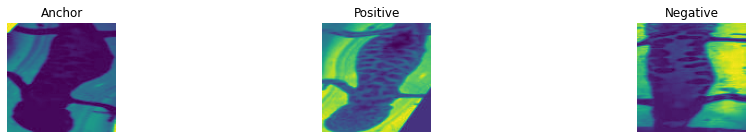

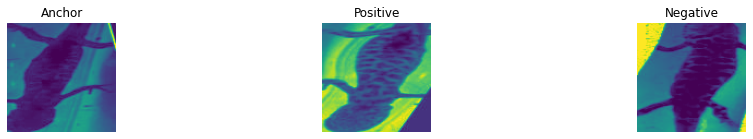

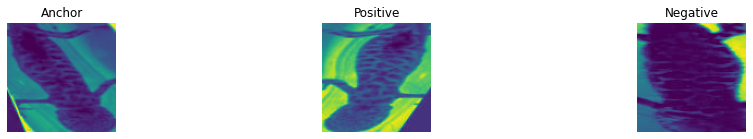

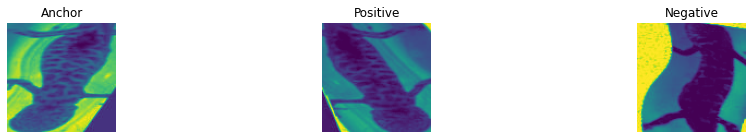

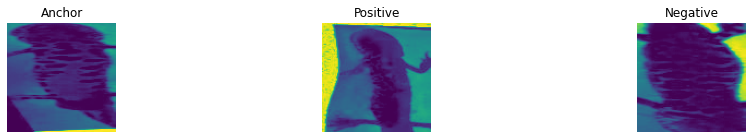

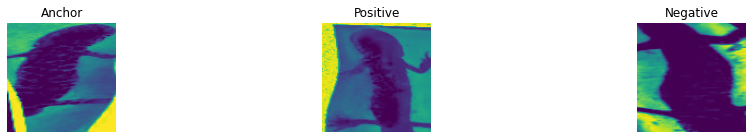

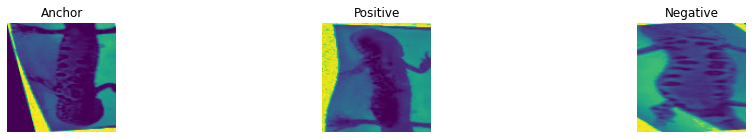

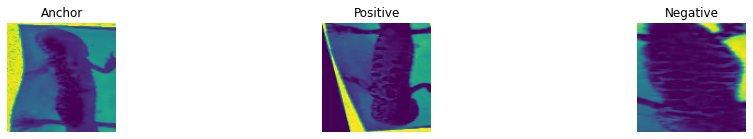

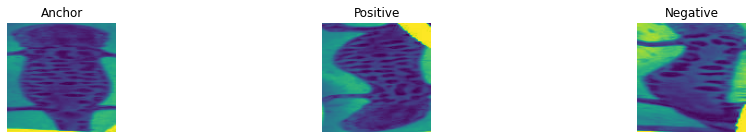

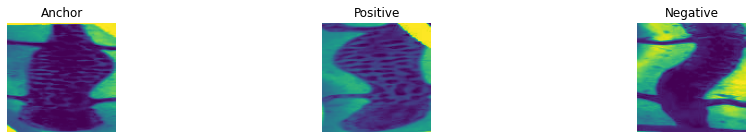

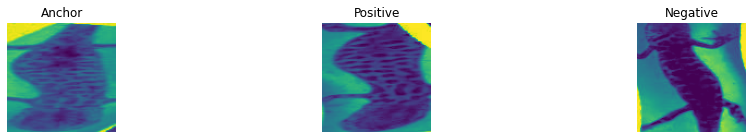

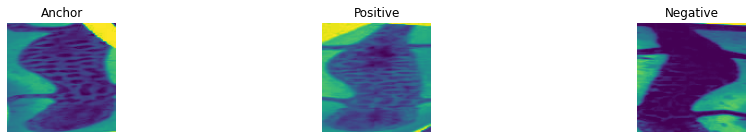

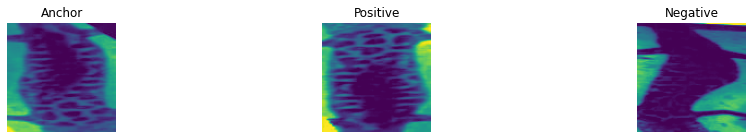

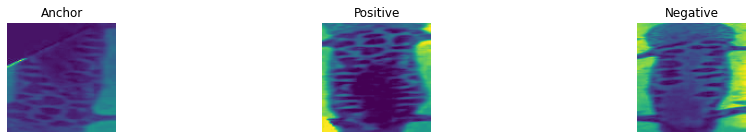

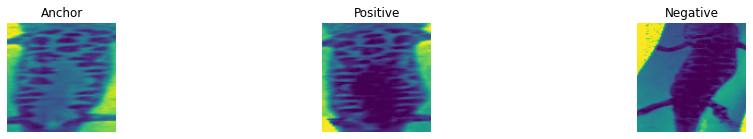

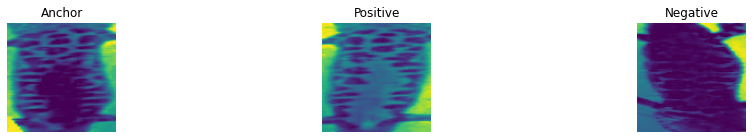

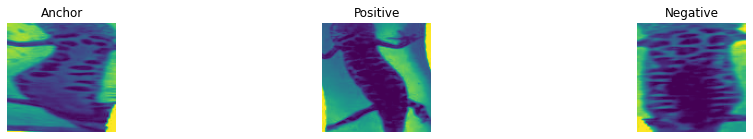

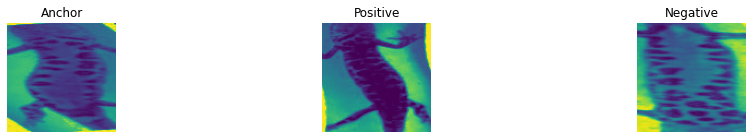

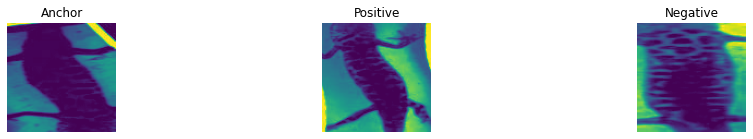

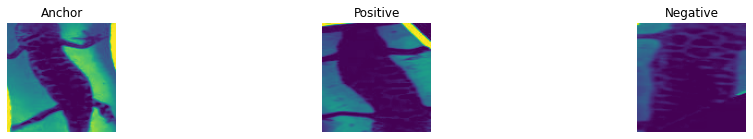

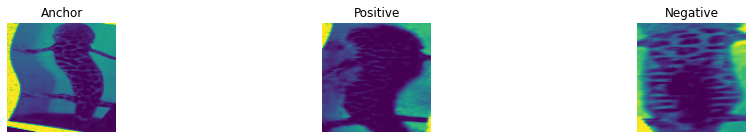

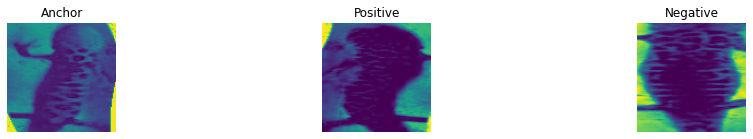

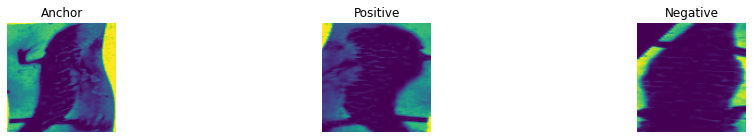

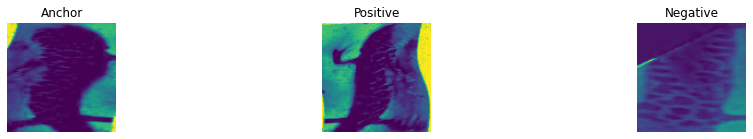

In [20]:


model = build_network(input_shape,128)


def get_batch_moderate(batch_size,network,dataset,s="train"):
    """
    Create batch of APN "moderate" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset
    else:
        X = dataset

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_moderate_random(batch_size,dataset,s)
    
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    #print(A.shape)
    P = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4]))
    N = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))  


    for i in range(studybatch[1].shape[4]):
      P[:,:,i] = network.predict(studybatch[1][:,:,:,:,i])
     # plt.figure()
     # plt.imshow(np.squeeze(studybatch[1][0,:,:,:,i]))
      #print(studybatch[1][:,:,:,:,i])
      #if(i>0):
       # print("Pi - Pi-1")
        #print(P[:,:,i] - P[:,:,i-1])
      for j in range(studybatch[2].shape[5]):
        N[:,:,i,j] = network.predict(studybatch[2][:,:,:,:,i,j])
        #if(i>0):
         # print("Ni,j - Ni-1,j")
          #print(N[:,:,i,j] - N[:,:,i-1,j])

    
    ### Extraction des indices des distances maximales
    
    A = tf.expand_dims(A, axis = -1)
    #print(A)
    #print(P)
    dist_p = tf.math.subtract(A,P)
    #print(dist_p)
    dist_p = tf.norm(tf.math.subtract(A,P),axis = -2)
    #print(dist_p)
    selectionAP = tf.math.argmax(tf.norm(A - P,axis = -2), axis = -1)
    #print(selectionAP)
   # print(selectionAP.shape)
    #dist_p = tf.dtypes.cast(dist_p, tf.double)

    
    sub = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))    
    for i in range(N.shape[3]):
      #print(A.shape)
      #print(tf.math.subtract(N[:,:,i+1,i],N[:,:,i,i]))
      sub[:,:,:,i] = tf.math.subtract(A,N[:,:,:,i])
      #print(sub[:,:,:,i])
    #A = tf.expand_dims(A, axis = -1)
    #print(sub)
    n_dist = tf.norm(sub,axis = 1)
    #print(n_dist)
    n_dist = tf.reduce_min(n_dist, axis = -2)
    #print("n_dist")
    #print(n_dist)
    selectionN = np.argmin(n_dist, axis = -1)
    #print("selectionN")
    #print(selectionN)
   # print(selectionN.shape)
    AN = tf.norm(sub,axis = -3)
    #print("AN")
    #print(AN)

    selectionPN = np.zeros((AN.shape[0]),dtype=np.int8)
    for i in range(AN.shape[0]):
      #print(AN[i,:,selectionN[i]])
      selectionPN[i] = np.argmin(AN[i,:,selectionN[i]])
      
      #print(selectionPN[i])
   # print("selectionPN")
    #print(selectionPN)
    #n_dist = tf.dtypes.cast(n_dist, tf.double)
    batch_size = studybatch[2][:,0,0,0,0,0].shape[0]
   # print(batch_size)
    width = studybatch[2][0,:,0,0,0,0].shape[0]
   # print(width)
    height = studybatch[2][0,0,:,0,0,0].shape[0]
   # print(height)
    channels = studybatch[2][0,0,0,:,0,0].shape[0]
   # print(channels)
    K = studybatch[2][0,0,0,0,:,0].shape[0]
   # print(K)
    N = studybatch[2][0,0,0,0,0,:].shape[0]
   # print(N)

    ### Création des tenseurs contenant les images sélectionnées de telles sortes à maximiser les distances AP et à minimiser les distances AN
    positives = tf.zeros((batch_size,width,height,channels))
    negatives = tf.zeros((batch_size,width,height,channels))

    #print(selectionPN)
    #print(selectionN)
    
    #print(P.shape)
    #print(N.shape)

    
    for i in range(studybatch[2][:,0,0,0,0,0].shape[0]):
      positives = studybatch[1][:,:,:,:,selectionAP[i]]
      #positives = np.squeeze(positives)
      #print(positives)
      #print(positives.shape)
      negatives = studybatch[2][:,:,:,:,selectionPN[i],selectionN[i]]
      #negatives = np.squeeze(negatives)
      #print(negatives.shape)

    #print(positives[0,:,:,0])
    #print(negatives[0,:,:,0])
    #print(positives[0,:,:,:])
    #print(negatives[0,:,:,:])
    #plt.figure()
    #plt.imshow(positives[0,:,:,0])
    #plt.figure()
    #plt.imshow(negatives[0,:,:,0])

    #studybatchloss = tf.math.reduce_sum(tf.math.log1p(tf.math.subtract(p_dist,n_dist)))
    #studybatchloss = tf.dtypes.cast(studybatchloss, tf.float32)

    triplets = [studybatch[0][:,:,:,:], positives, negatives]

    #print(NMin.shape)

    #Compute d(A,P)-d(A,N)
    #studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the inverse
    #selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    #selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    #selection = np.append(selection,selection2)
    
    #triplets = [A,P,N]
    #print(triplets.shape)
    return triplets

tripletbatch = get_batch_moderate(8, model, dataset)
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            plt.axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0])
            subplot.title.set_text(labels[i])

drawTriplets(tripletbatch=tripletbatch)



In [0]:

class TripletLossLayerModerate(layers.Layer):
    def __init__(self, **kwargs):
        #self.alpha = alpha
        super(TripletLossLayerModerate, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        A, P, N = inputs
        
        p_dist = tf.norm(A - P,axis = -1)
        n_dist = tf.norm(A - N,axis = -1)
        
        #tripletLoss = tf.math.reduce_sum(tf.math.add(self.alpha,tf.math.subtract(p_dist,n_dist)))

        #Utilisation de la formule de batch_hard du papier avec marge douce
        tripletLoss = tf.math.reduce_sum(tf.math.log1p(tf.math.exp(tf.math.subtract(p_dist,n_dist))))
        tripletLoss = tf.dtypes.cast(tripletLoss, tf.float32)
        #tripletLoss = backend.sum(backend.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        return(tripletLoss)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

Construction du modèle du papier

In [0]:
def build_model_moderate(input_shape, network, margin = 0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
    
    
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    #loss_layer = TripletLossLayerModerate(alpha = margin, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    loss_layer = TripletLossLayerModerate(name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train



In [0]:

import sklearn
from sklearn.metrics import roc_auc_score, roc_curve
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    distances = np.zeros(())
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes

                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                   # print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [0]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))
#count_label = len(dataset)

def mean_average_precision(X,Y,network,rank):
    '''
    Returns
        MAP : the mean of the average precision of the model for each images of the dataset
    '''
    nb_classes = count_label
    m = X.shape[0]
    #nbtrain = 10
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:,:,:,:]
          #print(selected_ref.shape)
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:]/255, axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    AP = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      print(ytrue)
      print(ypreds[i,0])
      for k in range(rank):
        
        if(ytrue[i] == ypreds[i,k]):
          AP += 1/(k+1)
    
    MAP = AP/len(ytrue)
    print(MAP)
    return MAP


def cumulative_matching_curve(X,Y,network,rank):
  
    '''
    Returns
        CMC : 
    '''
    nb_classes = count_label
    m = X.shape[0]
    nbtrain = 1000
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:nbtrain,:,:,:]
          #print(selected_ref.shape)
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:]/255, axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    present = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      for k in range(rank):
        #print(ytrue)
        #print(ypreds[i,k])
        if(ytrue[i] == ypreds[i,k]):
          present += 1
    
    CMC = present/len(ytrue)
    print(CMC)
    return CMC

    




def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    nb_classes = count_label
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,28,28,3))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

In [0]:
import time
embedding_size = 500
tf.keras.backend.clear_session()
model = build_network(input_shape,embedding_size)
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

#inter_dist = compute_interdist(model)
#print(inter_dist)

In [29]:


#model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, amsgrad=False))

n_iter = 3000
n_iteration = 0
evaluate_every = 10
n_val = 1000
print("Starting training process!")
print("-------------------------------------")

distribution = np.zeros((10,3))
t_start = time.time()
plt.figure()
for i in range(1, n_iter+1):
    triplets = get_batch_moderate(12,model,dataset)
    
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))

       # inter_dist = compute_interdist(model)
       # print(inter_dist)

        #MAP = mean_average_precision(x_train,y_train,model,1)
        #CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,5)
        #print("Mean Average Precision" + str(MAP))
        #print("Cumulative Matching Curve = " + str(CMC))
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)

Starting training process!
-------------------------------------

 ------------- 

[10] Time for 10 iterations: 0.7 mins, Train Loss: 26.26023292541504

 ------------- 

[20] Time for 20 iterations: 1.4 mins, Train Loss: 24.21698570251465

 ------------- 

[30] Time for 30 iterations: 2.1 mins, Train Loss: 27.13367462158203

 ------------- 

[40] Time for 40 iterations: 2.7 mins, Train Loss: 24.336339950561523

 ------------- 

[50] Time for 50 iterations: 3.4 mins, Train Loss: 23.316049575805664

 ------------- 

[60] Time for 60 iterations: 4.1 mins, Train Loss: 22.240995407104492

 ------------- 

[70] Time for 70 iterations: 4.7 mins, Train Loss: 21.018997192382812

 ------------- 

[80] Time for 80 iterations: 5.4 mins, Train Loss: 20.357515335083008

 ------------- 

[90] Time for 90 iterations: 6.1 mins, Train Loss: 27.240407943725586

 ------------- 

[100] Time for 100 iterations: 6.8 mins, Train Loss: 22.14120864868164

 ------------- 

[110] Time for 110 iterations: 7.4 mins

KeyboardInterrupt: ignored

<Figure size 864x360 with 0 Axes>

In [0]:
import io
import tensorflow_datasets as tfds

results = model.predict(x_test)
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for labels in y_test:
    out_m.write(str(labels) + "\n")
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

In [0]:
#print(dataset_train)
MAP = mean_average_precision(x_test,y_test,model,1)

1.7532509687630087
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [0]:
CMC = cumulative_matching_curve(x_test,y_test,model,3)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

In [1]:
import tensorflow_addons as tfa
input_shape = [100,100,3]
#model = build_network(input_shape, 128)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    x_train,
    y_train,
    epochs=5)



NameError: ignored

In [0]:
# Evaluate the network
results = model.predict(tfds_test)
results

In [0]:

MAP = mean_average_precision(x_test,y_test,model,1)

nan
0


KeyboardInterrupt: ignored

In [0]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

NameError: ignored

In [0]:
!zip -r /content/newtsAugmented.zip /content/databaseAug

Streaming output truncated to the last 5000 lines.
  adding: content/databaseAug/train/KM00716/Bascha_P01_T02_K17_M_Adult_6362_201906262226068.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T01_K16_M_Adult_1826_201906221654411.jpg (deflated 6%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_565_2019052302285113.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_572_201905230546425.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_577_2019052312284615.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K17_M_Adult_11610_2019062906090413.jpg (deflated 6%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T01_K16_M_Adult_1826_201906221654413.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_577_2019052312284616.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adu

In [0]:
from sklearn.decomposition import PCA

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, amsgrad=False))

n_iteration = 0
t_start = time.time()
plt.figure()
for i in range(1, 10+1):
    triplets = get_batch_moderate(14,model)
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    
print("\n ------------- \n")
print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(10, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))

pca = PCA(n_components=2)
pca.fit(model.predict(x_test_origin[:n_val,:,:,:]))
print(pca)
plt.imshow(pca)
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)


 ------------- 

[10] Time for 10 iterations: 0.2 mins, Train Loss: 13.344663619995117


AttributeError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
pca = PCA(n_components=2)
Xproj = pca.fit_transform(model.predict(x_test_origin[:n_val,:,:,:]))
print(Xproj)
plt.scatter(Xproj)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


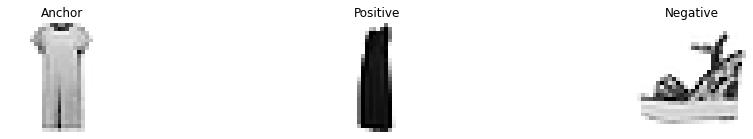

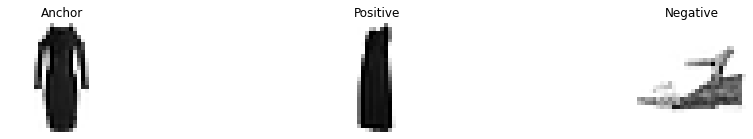

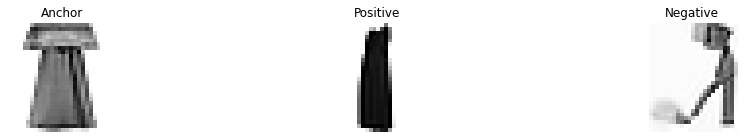

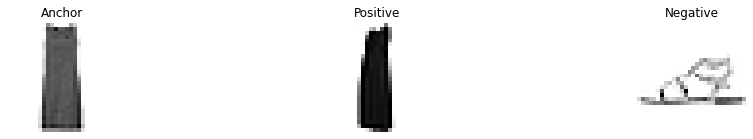

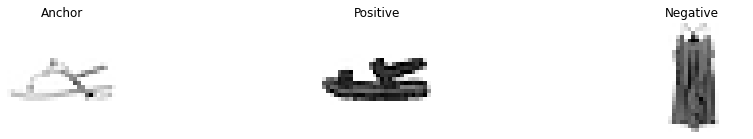

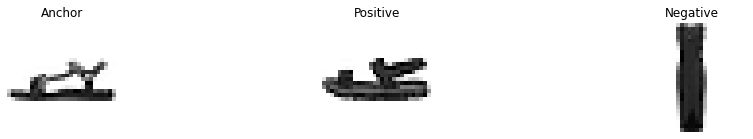

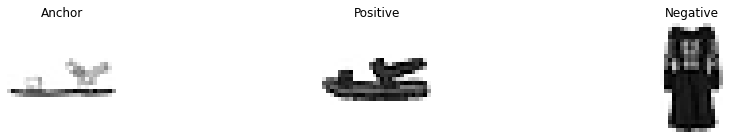

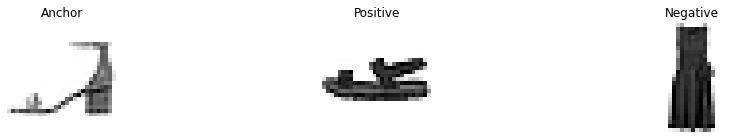

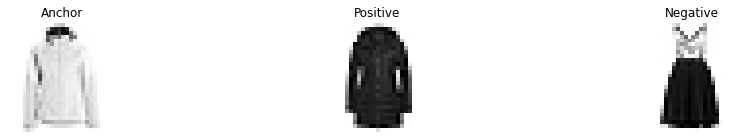

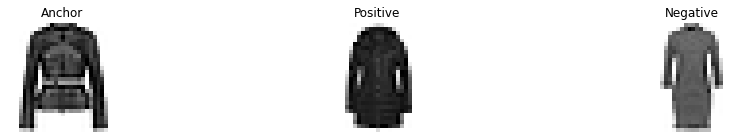

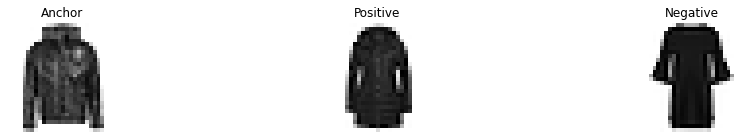

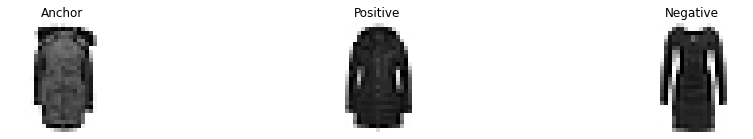

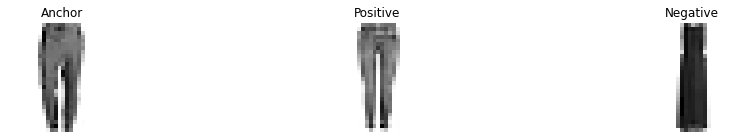

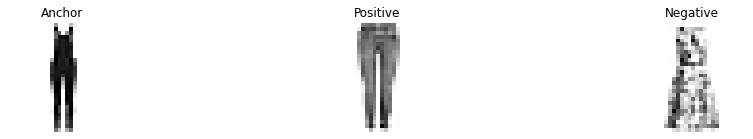

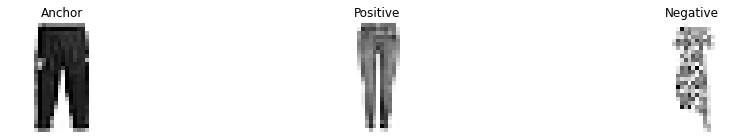

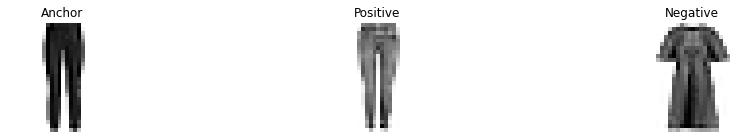

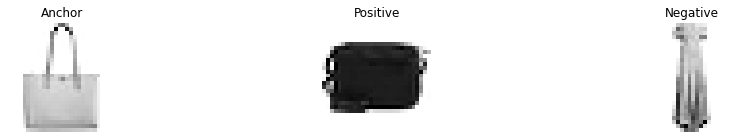

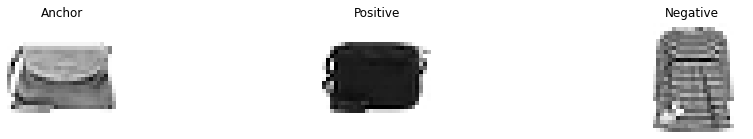

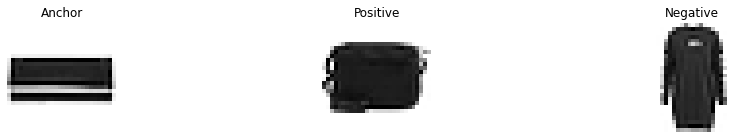

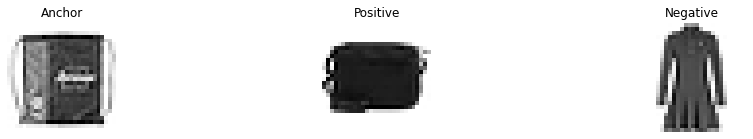

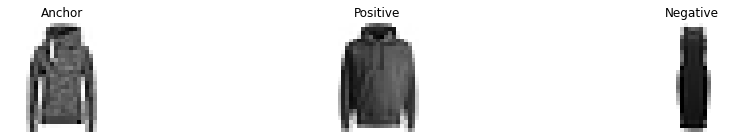

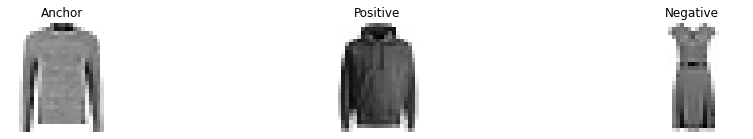

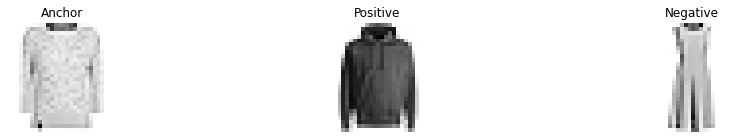

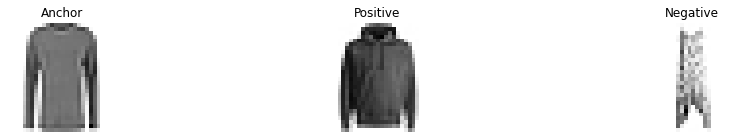

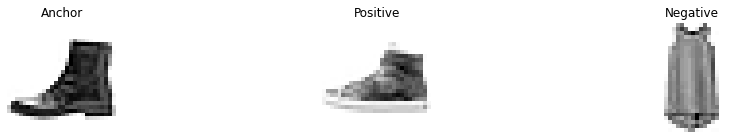

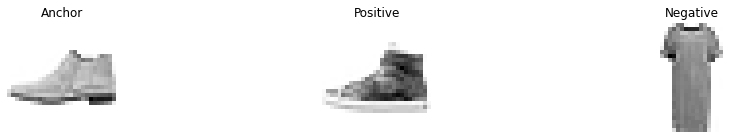

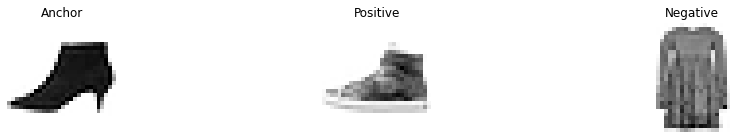

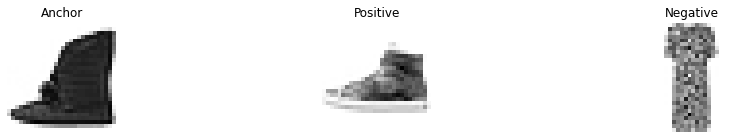

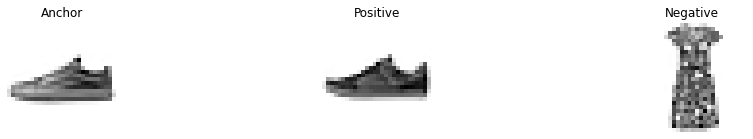

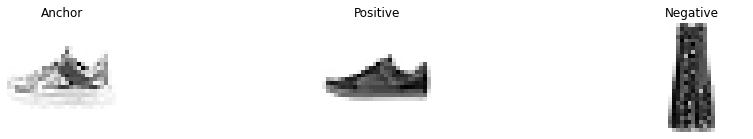

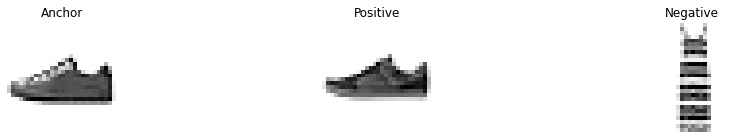

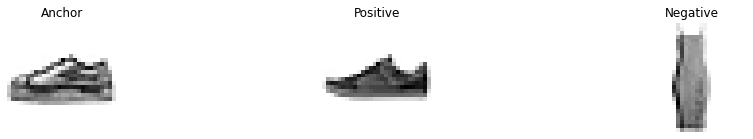

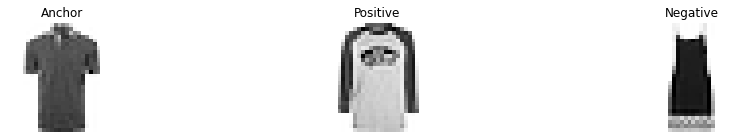

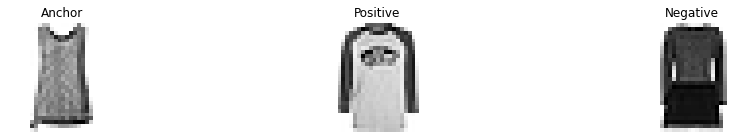

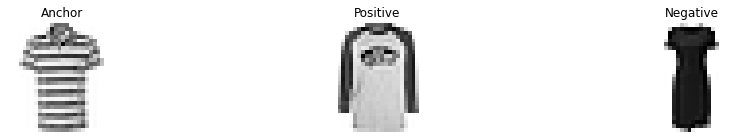

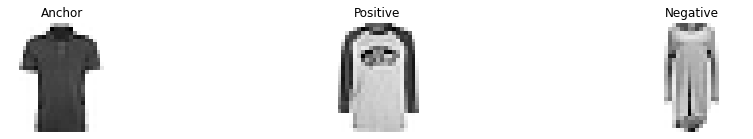

In [0]:
triplets = get_batch_moderate(12,model)
drawTriplets(triplets)

In [0]:
CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,1)

(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
0.124


In [0]:
inter_dist = compute_interdist(model)
print(inter_dist)


[[  0.         120.01339722 398.2928772  ... 598.70098877 371.48931885
  737.97625732]
 [120.01339722   0.         144.54165649 ... 478.15609741 246.51008606
  571.08312988]
 [398.2928772  144.54165649   0.         ... 483.98950195 330.13873291
  519.56286621]
 ...
 [598.70098877 478.15609741 483.98950195 ...   0.          59.39736176
   17.40637779]
 [371.48931885 246.51008606 330.13873291 ...  59.39736176   0.
  113.35768127]
 [737.97625732 571.08312988 519.56286621 ...  17.40637779 113.35768127
    0.        ]]


Debuggage

In [0]:


import time


tf.keras.backend.clear_session()
model = build_network(input_shape,64)
model_trained = 0
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
n_val = 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 ------------- 

loss = 0.18179337680339813


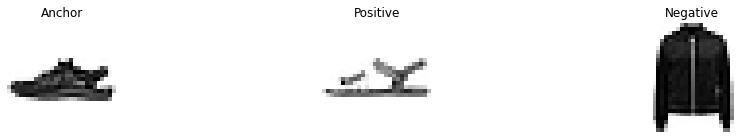

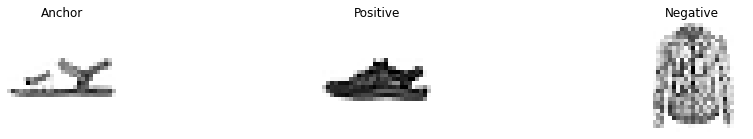

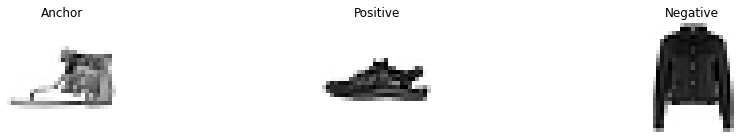

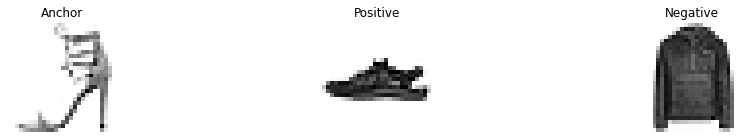

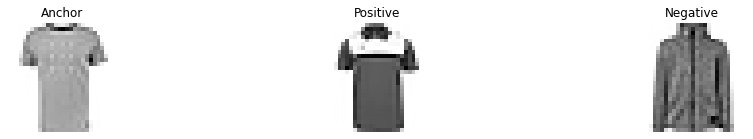

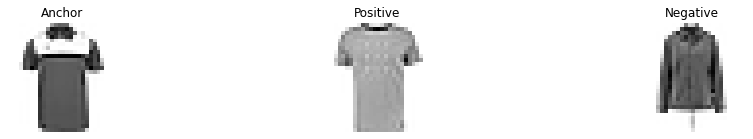

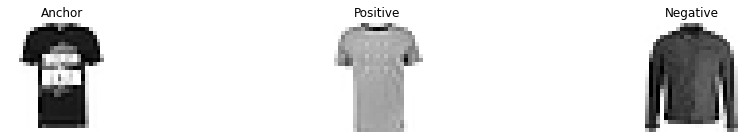

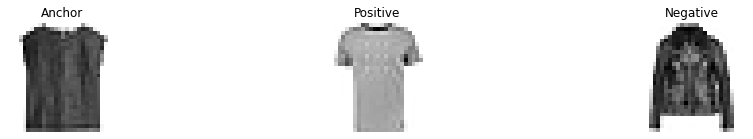

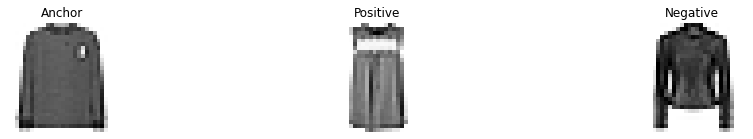

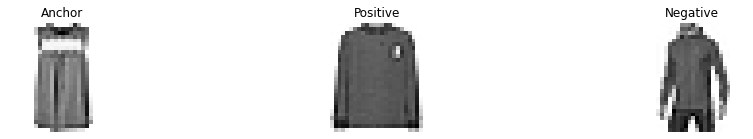

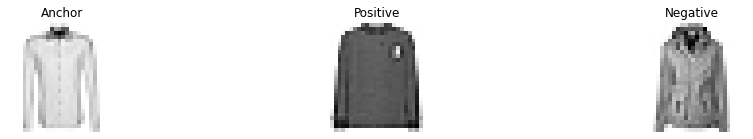

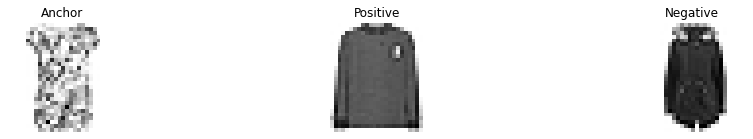

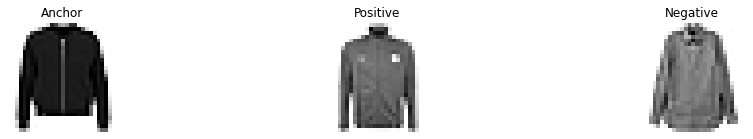

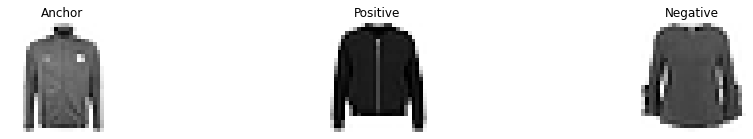

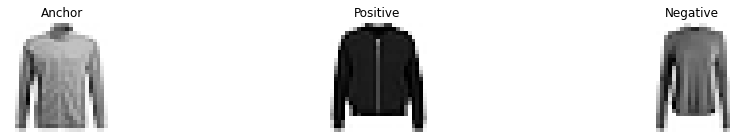

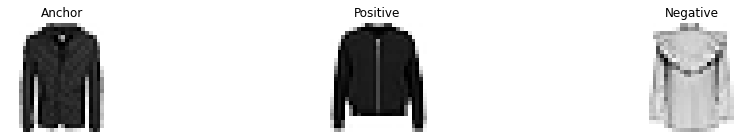

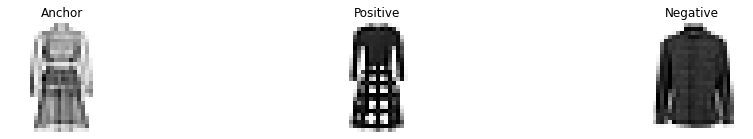

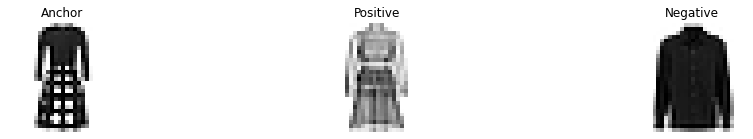

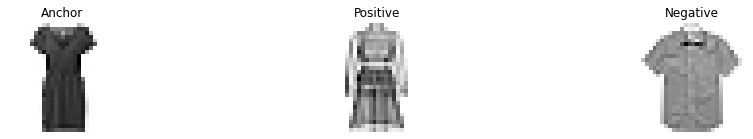

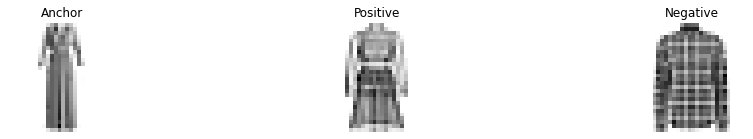

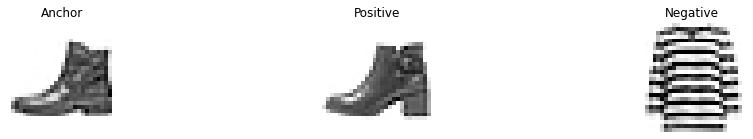

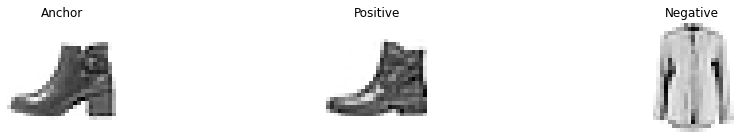

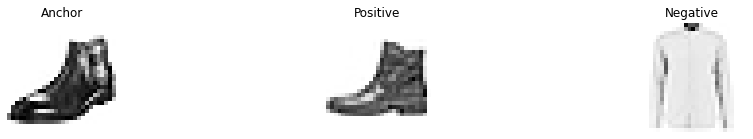

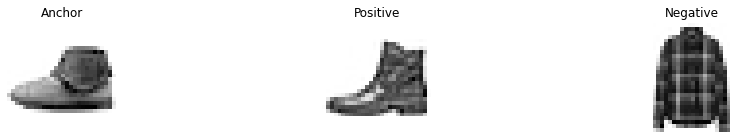

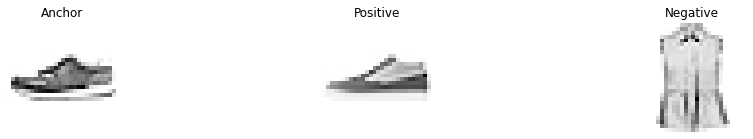

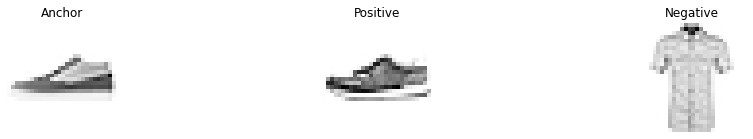

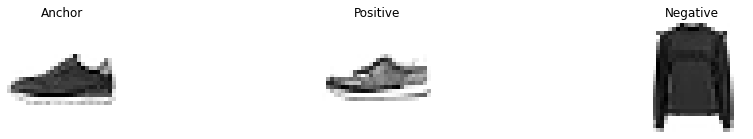

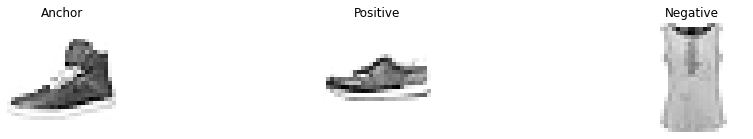

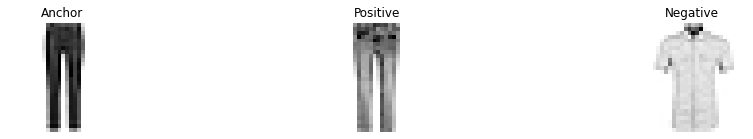

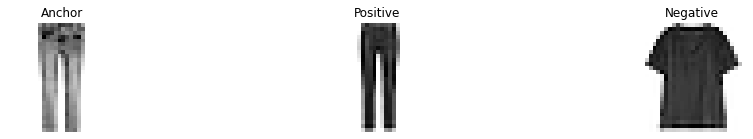

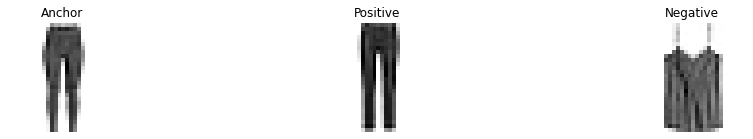

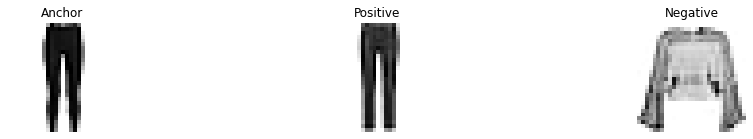

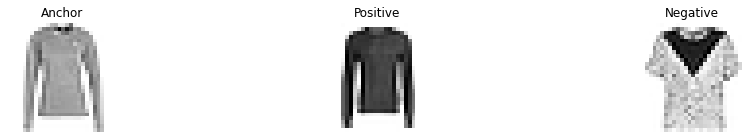

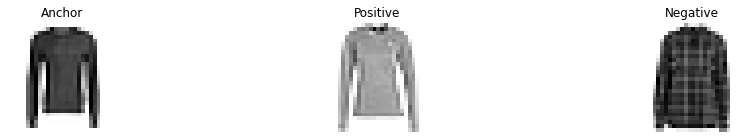

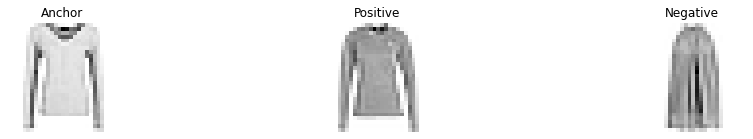

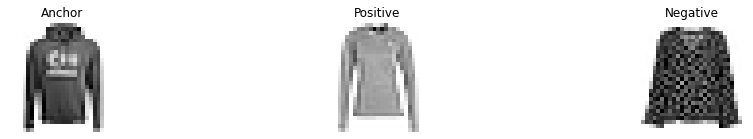

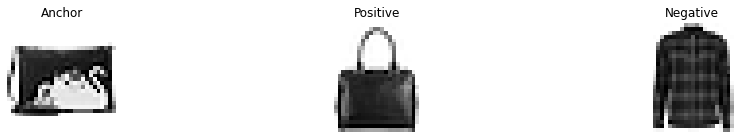

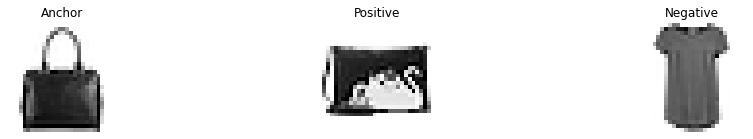

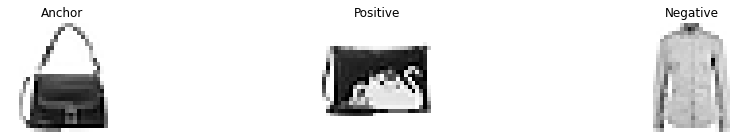

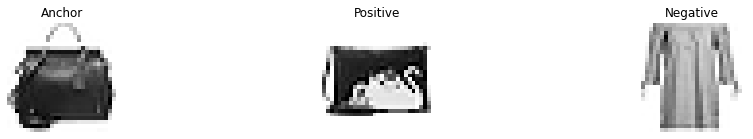

In [0]:
triplets = get_batch_moderate(14,model)
drawTriplets(tripletbatch=triplets)
#print(triplets.shape)
loss = model_trained.train_on_batch(triplets, None)

print("\n ------------- \n")
print("loss = " + str(loss))
probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])


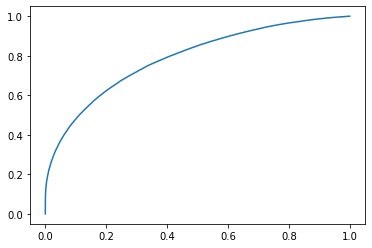

In [0]:
#compute_interdist(model)
probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)

plt.figure()
plt.plot(fpr,tpr)

#plt.plot(thresholds)
